In [1]:
# importe 
import numpy as np 
import matplotlib.pyplot as plt 
import json
from graph_tool.all import *


In [2]:
# euklidian distance in 38d-space
def calc_euklidian_dist(list1, list2): 
    if len(list1) != len(list2): 
        print("ungleich lange listen, exiting ...")
        return False 
    tmp = 0 
    for i in range(len(list1)): 
        tmp +=  (list1[i] - list2[i]) **2 
    return np.sqrt(tmp)


In [3]:
with open('all.json', 'r') as fp:
    allelect = json.load(fp)

27
Bundestagswahl
test overlap [0.5556 0.4074 0.6667 0.     0.    ]
test edge_descriptors [1][1]  0
<EdgePropertyMap object with value type 'double', for Graph 0x7f2a326bb450, at 0x7f2a326bb550>


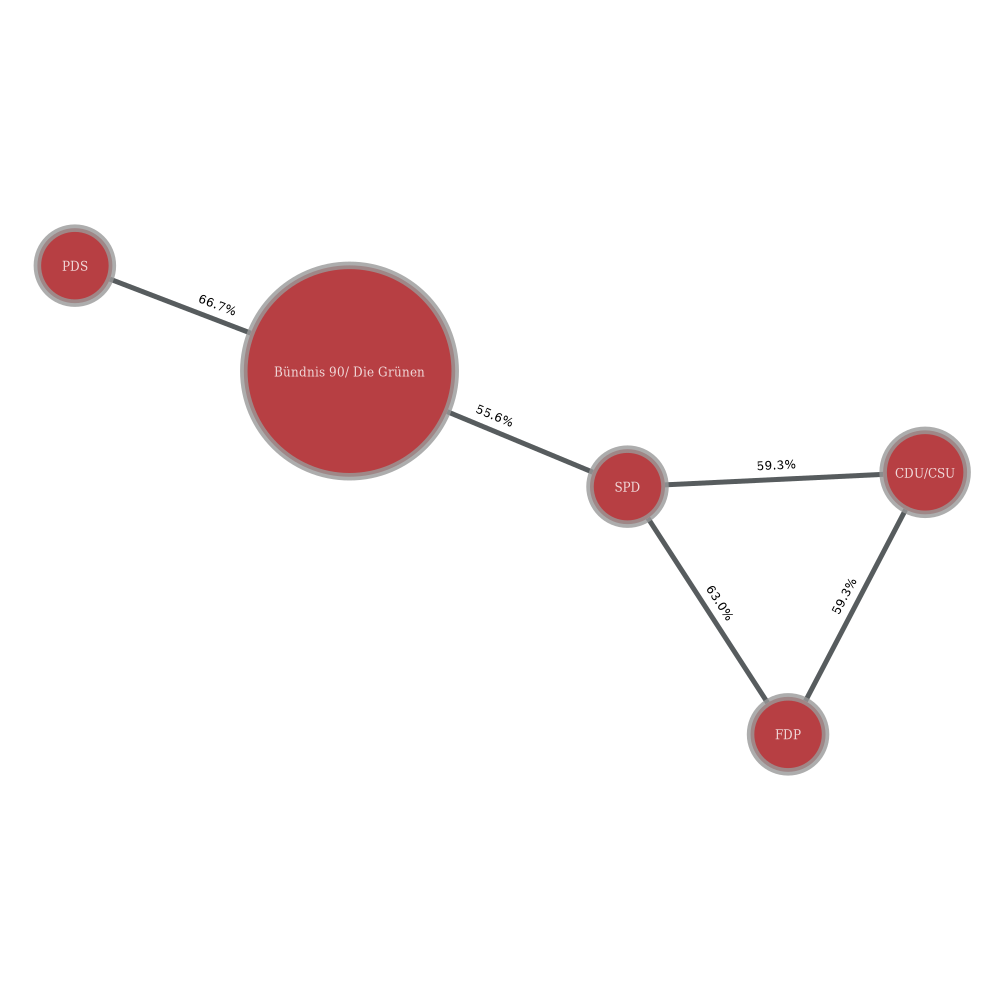

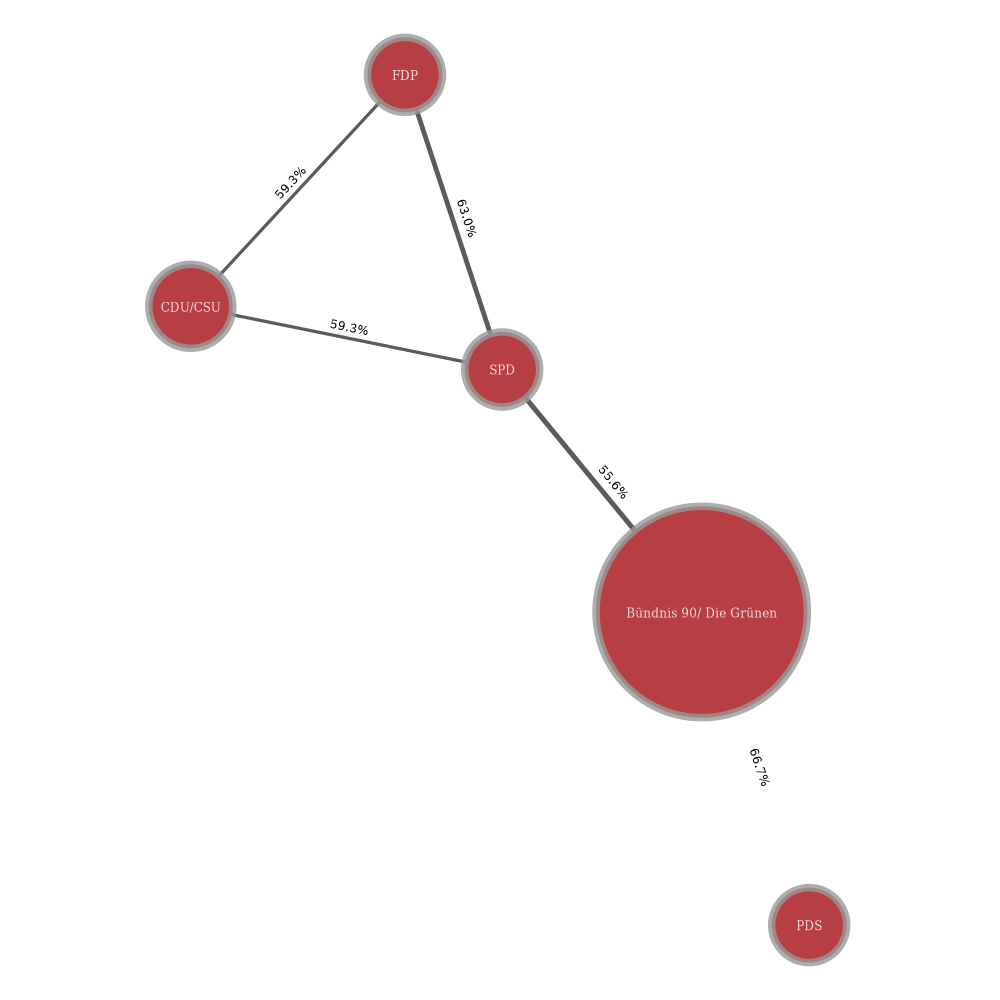

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2a326bb450, at 0x7f2a326bbb50>

In [4]:
i='0' ## HERE LOOP FOR ALL ELECTIONS
parteinames=allelect[i]['parties']['name']
list_of_lists= allelect[i]['parties']['position']
N_analyzed_parties  = len(list_of_lists)
N_fragen  = len(list_of_lists[0])
print(N_fragen)
print(allelect[i]['wahl'])
# calculate euklidian distances:
euklidian_distances = np.zeros((N_analyzed_parties, N_analyzed_parties), dtype=float)
for i in range( N_analyzed_parties ):
    for j in range( N_analyzed_parties ): 
        euklidian_distances[i][j] = calc_euklidian_dist( list_of_lists[i], list_of_lists[j] )


overlap = np.zeros(( N_analyzed_parties ,N_analyzed_parties ), dtype="float")
for i in range( N_analyzed_parties ): 
    for j in range( N_analyzed_parties ):
        if i >j:
            temp=[ii for ii, jj in zip(list_of_lists[i], list_of_lists[j]) if ii == jj]
            overlap[i][j] = round(len(temp)/N_fragen , 4)
print("test overlap", overlap[3])

diagramm = graph_tool.Graph()
diagramm.set_directed(False)
# property_maps 
couplings         = diagramm.new_edge_property("float")
couplings_re      = diagramm.new_edge_property("float")
couplings_eukl_38 = diagramm.new_edge_property("float")
couplings_text    = diagramm.new_edge_property("string")
vertex_labels_by_party = diagramm.new_vertex_property("string")          # doubles
couplings = diagramm.new_edge_property("float")

vertices = []
for xx in parteinames: 
    vertices.append(diagramm.add_vertex())


for qq in range(len(parteinames)): 
    vertex_labels_by_party[vertices[qq]] = parteinames[qq]
    
    
    
# fill the property-maps
edge_descriptors = np.zeros((N_analyzed_parties,N_analyzed_parties), dtype=np.dtype(object) )
print("test edge_descriptors [1][1] ", edge_descriptors[1][1])
min_overlap = np.amin(overlap)
for vertex1 in diagramm.vertices(): 
    for vertex2 in diagramm.vertices(): 
        # no self-loops
        if vertex1 != vertex2: 
            index1 = parteinames.index(vertex_labels_by_party[vertex1])
            index2 = parteinames.index(vertex_labels_by_party[vertex2])
            # create edges only for reasonable similar parties
            if overlap[index1][index2] > 0.5:
                a = diagramm.add_edge(vertex1, vertex2)
                edge_descriptors[ index1 ][ index2 ] = a
                couplings[a] = overlap[index1][index2]
                couplings_re[a] = overlap[index1][index2] - min_overlap
                couplings_text[a] = str(round(100*overlap[index1][index2],1))+"%"
                couplings_eukl_38[a] = euklidian_distances[index1][index2]
            #print("edge_descriptors[ index1 ][ index2 ]", edge_descriptors[ index1 ][ index2 ])
            
# use cool spring-layouting algorithm
positions1 = sfdp_layout(diagramm, K=1000 , C=5, p=5, eweight=couplings)
positions2 = sfdp_layout(diagramm, K=1000 , C=5, p=5, eweight=couplings_eukl_38)

print(couplings)
# plot the whole thing  
graph_draw(diagramm, 
            vertex_text=vertex_labels_by_party, 
            vertex_size=75, 
            output_size=(1000,1000),
            edge_pen_width=prop_to_size(couplings, mi=5),
            pos=positions1,
            edge_text=couplings_text,
            bg_color = [255,255,255,1],
            # output="overlap_eu.png"
            )

graph_draw(diagramm, 
            vertex_text=vertex_labels_by_party, 
            vertex_size=75,
            output_size=(1000,1000),
            edge_pen_width=prop_to_size(couplings_eukl_38),
            pos=positions2,
            edge_text=couplings_text,
            bg_color = [255,255,255,1],
            # output="euklidian_eu.png"
            )